In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
# --------- Data Loading and Preprocessing ---------
dataset_path = r"C:\Users\admin\Downloads\Bean_Dataset\Bean_Dataset"  # <-- Update path as needed

batch_size = 32
img_height = 180
img_width = 180

# Load datasets with train/validation split
full_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

valid_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Retrieve class names
class_names = full_ds.class_names
num_classes = len(class_names)
print("Classes found:", class_names)
print("Number of classes:", num_classes)


Found 990 files belonging to 3 classes.
Using 792 files for training.
Found 990 files belonging to 3 classes.
Using 198 files for validation.
Classes found: ['angular_leaf_spot', 'bean_rust', 'healthy']
Number of classes: 3


In [31]:
# Debug: Check labels in training and validation datasets
for images, labels in full_ds.take(1):
    print("Sample labels in training:", labels.numpy())
    print("Labels range:", labels.numpy().min(), labels.numpy().max())

for images, labels in valid_ds.take(1):
    print("Sample labels in validation:", labels.numpy())
    print("Labels range:", labels.numpy().min(), labels.numpy().max())

# Data performance optimization
AUTOTUNE = tf.data.AUTOTUNE
full_ds = full_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Normalize images
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = full_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))

Sample labels in training: [0 1 0 1 2 2 2 2 0 1 1 2 0 2 2 2 2 2 2 2 1 0 1 2 2 1 0 0 1 2 2 1]
Labels range: 0 2
Sample labels in validation: [2 1 2 1 0 1 0 2 2 0 0 0 2 1 2 0 2 1 0 1 0 1 0 1 2 0 0 0 1 1 0 2]
Labels range: 0 2


In [32]:
# --------- Model Definitions ---------
def create_cnn_model():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

def create_dnn_model():
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(img_height, img_width, 3)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])


In [33]:
# Instantiate models
cnn_model = create_cnn_model()
dnn_model = create_dnn_model()

In [34]:
# Compile models
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
dnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [35]:
# --------- Model Training ---------
print("Training CNN model...")
cnn_history = cnn_model.fit(train_ds, validation_data=valid_ds, epochs=10)

print("Training DNN model...")
dnn_history = dnn_model.fit(train_ds, validation_data=valid_ds, epochs=10)

Training CNN model...
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 495ms/step - accuracy: 0.3837 - loss: 3.1478 - val_accuracy: 0.5758 - val_loss: 0.9125
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 467ms/step - accuracy: 0.5813 - loss: 0.8978 - val_accuracy: 0.6768 - val_loss: 0.6998
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 489ms/step - accuracy: 0.7440 - loss: 0.6161 - val_accuracy: 0.7626 - val_loss: 0.6318
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 451ms/step - accuracy: 0.8411 - loss: 0.4547 - val_accuracy: 0.7071 - val_loss: 0.7744
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 435ms/step - accuracy: 0.9102 - loss: 0.3185 - val_accuracy: 0.7222 - val_loss: 0.6477
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 446ms/step - accuracy: 0.9458 - loss: 0.1821 - val_accuracy: 0.7475 - val_loss: 0.6878
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - accuracy: 0.9838 - loss: 0.0916 - val_accuracy: 0.7576 - val_loss: 0.7794
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 437ms/step - accuracy: 0.9881 - l

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7327 - loss: 0.9976
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5104 - loss: 1.7612

CNN Model Accuracy: 72.73%
DNN Model Accuracy: 50.00%


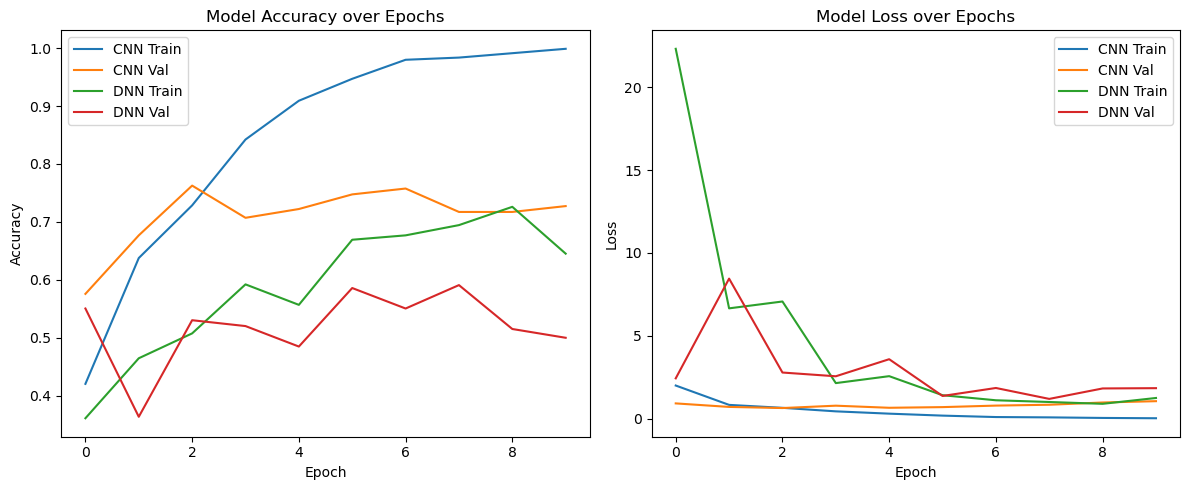

In [36]:
# --------- Evaluations ---------
cnn_eval = cnn_model.evaluate(valid_ds)
dnn_eval = dnn_model.evaluate(valid_ds)

print(f"\nCNN Model Accuracy: {cnn_eval[1]*100:.2f}%")
print(f"DNN Model Accuracy: {dnn_eval[1]*100:.2f}%")

# --------- Plot Accuracy & Loss ---------
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='CNN Train')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Val')
plt.plot(dnn_history.history['accuracy'], label='DNN Train')
plt.plot(dnn_history.history['val_accuracy'], label='DNN Val')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='CNN Train')
plt.plot(cnn_history.history['val_loss'], label='CNN Val')
plt.plot(dnn_history.history['loss'], label='DNN Train')
plt.plot(dnn_history.history['val_loss'], label='DNN Val')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

CNN Model Evaluation:


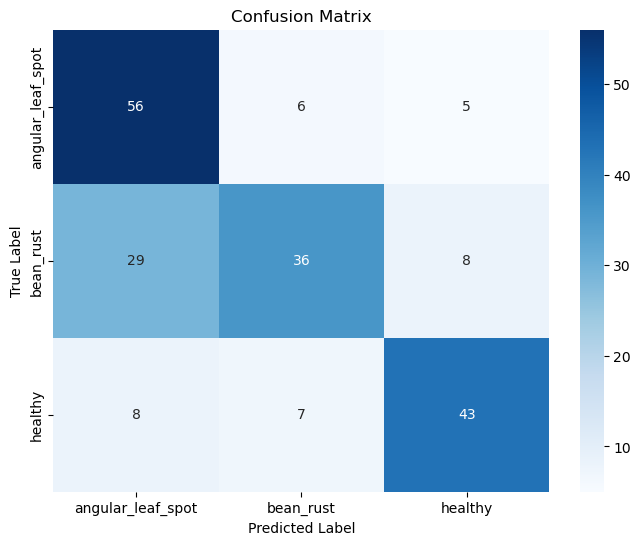

Classification Report:
                   precision    recall  f1-score   support

angular_leaf_spot       0.60      0.84      0.70        67
        bean_rust       0.73      0.49      0.59        73
          healthy       0.77      0.74      0.75        58

         accuracy                           0.68       198
        macro avg       0.70      0.69      0.68       198
     weighted avg       0.70      0.68      0.68       198


DNN Model Evaluation:


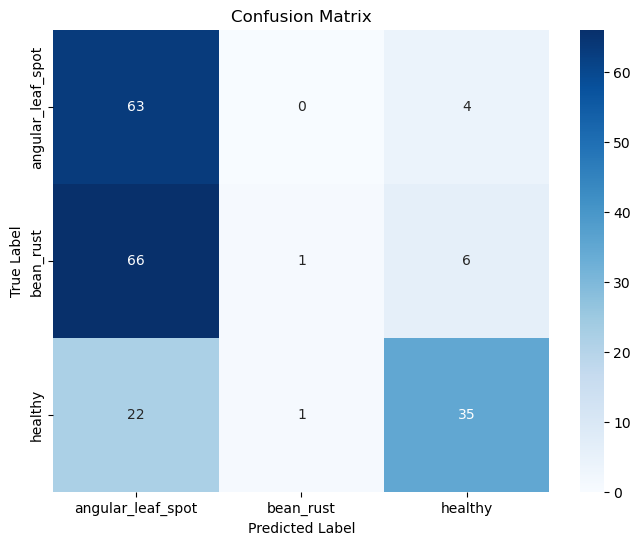

Classification Report:
                   precision    recall  f1-score   support

angular_leaf_spot       0.42      0.94      0.58        67
        bean_rust       0.50      0.01      0.03        73
          healthy       0.78      0.60      0.68        58

         accuracy                           0.50       198
        macro avg       0.56      0.52      0.43       198
     weighted avg       0.55      0.50      0.40       198



In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataset, class_names):
    # Get all true labels and predictions
    y_true = []
    y_pred = []
    
    for images, labels in dataset:
        y_true.extend(labels.numpy())
        predictions = model.predict(images, verbose=0)
        y_pred.extend(np.argmax(predictions, axis=1))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    return y_true, y_pred

# Evaluate CNN Model
print("CNN Model Evaluation:")
cnn_true, cnn_pred = evaluate_model(cnn_model, valid_ds, class_names)

# Evaluate DNN Model
print("\nDNN Model Evaluation:")
dnn_true, dnn_pred = evaluate_model(dnn_model, valid_ds, class_names)